<a href="https://colab.research.google.com/github/Aniket18-bot/PREDICTIVE-ANALYSIS-USING-MACHINE-LEARNING/blob/main/predectiveanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier


In [ ]:
# Load datasets
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ratings.csv")
movies = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/movies.csv")

# Merge ratings and movies
df = pd.merge(ratings, movies, on="movieId", how="left")
print("✅ Merged shape:", df.shape)
df.head()


✅ Merged shape: (100836, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
# Convert timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

# Binary label (positive vs negative rating)
df["rating_binary"] = df["rating"].apply(lambda x: 1 if x >= 4 else 0)

# --- Add genre dummies ---
genres_split = df["genres"].str.get_dummies(sep='|')
df_processed = pd.concat([df, genres_split], axis=1)

# --- Add user/movie averages ---
user_mean = df_processed.groupby("userId")["rating"].mean().rename("user_mean")
movie_mean = df_processed.groupby("movieId")["rating"].mean().rename("movie_mean")

df_processed = df_processed.merge(user_mean, on="userId", how="left")
df_processed = df_processed.merge(movie_mean, on="movieId", how="left")

In [ ]:
feature_cols = ["user_mean", "movie_mean", "hour", "dayofweek"] + list(genres_split.columns)
X = df_processed[feature_cols]
y = df_processed["rating_binary"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)

In [ ]:
# Model Evaluation

print("🔹 XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

🔹 XGBoost Results:
Accuracy: 0.7529750099166997
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76     10477
           1       0.74      0.76      0.75      9691

    accuracy                           0.75     20168
   macro avg       0.75      0.75      0.75     20168
weighted avg       0.75      0.75      0.75     20168

ROC AUC Score: 0.7531914550367057


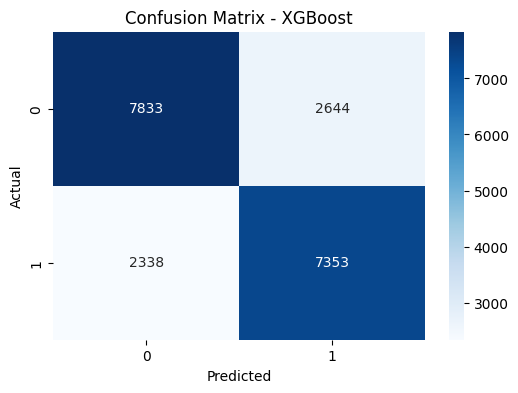

In [ ]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

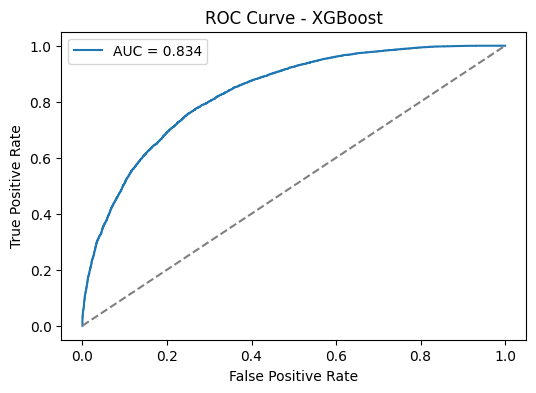

In [ ]:
# ROC Curve
y_prob = model.predict_proba(X_test.values)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

/tmp/ipython-input-4262883907.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette="viridis")


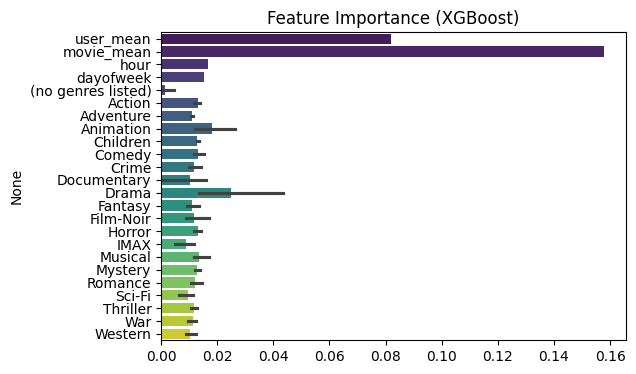

In [ ]:
# STEP 7: Feature Importance

feature_importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(6,4))
sns.barplot(x=feature_importances, y=features, palette="viridis")
plt.title("Feature Importance (XGBoost)")
plt.show()

In [ ]:
# STEP 8: Predictive Insights

print("✅ Model Training Complete.")
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Top Predictive Features:", list(features[np.argsort(feature_importances)[::-1]]))

✅ Model Training Complete.
XGBoost Accuracy: 0.7530
Top Predictive Features: ['movie_mean', 'user_mean', 'Drama', 'Animation', 'Drama', 'Musical', 'Film-Noir', 'hour', 'Documentary', 'Animation', 'Comedy', 'dayofweek', 'Documentary', 'Romance', 'Horror', 'Crime', 'Action', 'Mystery', 'Children', 'Drama', 'Fantasy', 'Action', 'Horror', 'Children', 'Children', 'Thriller', 'Comedy', 'Western', 'War', 'Musical', 'Mystery', 'Mystery', 'Animation', 'War', 'Action', 'Horror', 'Comedy', 'Thriller', 'Adventure', 'Musical', 'IMAX', 'Romance', 'Sci-Fi', 'Sci-Fi', 'Fantasy', 'Crime', 'Adventure', 'Adventure', 'Romance', 'Thriller', 'IMAX', 'Crime', 'Western', 'War', 'Fantasy', 'Film-Noir', 'Film-Noir', 'Western', 'Sci-Fi', 'IMAX', '(no genres listed)', 'Documentary', '(no genres listed)', '(no genres listed)']
